Here I want to explore how to evaluate expectation values in Qiskit, to analyze the VQE results  
Most of the stuff is explained here https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html  
These issue tickets are somewhat also helpful  
[Inconsistence between qasm and eval outputs of opflow expectation value #6255](https://github.com/Qiskit/qiskit-terra/issues/6255)  
[Opflow takes the adjoint of an Operator if the expectation value is written as OperatorMeasurement #6254](https://github.com/Qiskit/qiskit-terra/issues/6254)  

In [87]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
%matplotlib inline

In [114]:
# copypaste niccolo's code
def QNKron(N,op1,op2,pos): 
    '''
    Tensor product operator (Qiskit Pauli operators)
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    '''
    temp=np.array([I]*(N))
    temp[pos]=op1 
    if pos!=(N-1):
        temp[pos+1]=op2
    mat=1
    for j in range(N):
        mat=mat^temp[j]
    return mat
def QHIsing(N,lam,p):
    '''
    Quantum Ising Hamiltonian (1D) with transverse field (Qiskit Pauli operators)
    
    N:number of sites 
    lam: transverse field)
    '''

    H=-QNKron(N,Z,Z,0)-lam*QNKron(N,X,I,0)-p*QNKron(N,Z,I,0)
    for i in range(1,N-1):
        H=H-QNKron(N,Z,Z,i)-lam*QNKron(N,X,I,i)-p*QNKron(N,Z,I,i)
    H=H-lam*QNKron(N,X,I,N-1)-p*QNKron(N,Z,I,N-1)
    return H

def NKron(N,op1,op2,pos): 
    '''
    Tensor product operator 
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    
    '''
    ide=np.eye(2)
    temp=np.array([ide]*(N),dtype=np.complex128)
    temp[pos,:,:]=op1 
    # if pos!=(N-1):
    temp[(pos+1)%N,:,:]=op2
    mat=1
    for j in range(N):
        mat=np.kron(mat,temp[j])
    return mat

def Mag(N): #magnetization operator (numpy array)
    sz=np.array([[1,0],[0,-1]])
    M=np.zeros((2**N,2**N))
    for i in range(N):
        M=M+NKron(N,sz,np.eye(2),i)
    return M/N

def QMag(N): #magnetization operator (Qiskit operator)
    M=QNKron(N,Z,I,0)
    for i in range(1,N):
        M=M+QNKron(N,Z,I,i)
    return M/N

def ising_groundstate(L, J, g, p):
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + J*sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_x = H_x + g*sx_list[i] +p*sz_list[i]
    H = - H_zz - H_x
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0], H

def sort_vals(vals):
    """ vals is (unsorted) dictionary of parameters from VQE ansatz circuit, this returns sorted values as list """
    indices = np.array([_.index for _ in vals])           # unordered list of indices from the ParameterVectorElement(Theta(INDEX))
    vals_sorted = np.array([vals[_] for _ in vals])       # unordered list of values (but same ordering as indices)
    return vals_sorted[np.argsort(indices)]

def init_vqe(vals):
    return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(sort_vals(vals))



In [129]:
L = 6
VQE_vals = np.load(f'params_VQE_ising_N{L}.npy', allow_pickle=True).item()
lambdas = np.array([_ for _ in VQE_vals]) # list of lambda values (the items in the dictionary)
# note that Rike calls them gs
mag = QMag(L) #magnetization operator (Qiskit)
Smag=Mag(L) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(lambdas)); Sen=np.zeros(len(lambdas)) #energies
Qmags=np.zeros(len(lambdas)); Smags=np.zeros(len(lambdas)) #magnetizations

In [131]:
for j,lambda0 in enumerate(lambdas):
    print(lambda0)
    H = QHIsing(L,np.float32(lambda0),1e-4) # build Hamiltonian Op
    state = init_vqe(VQE_vals[lambda0])
    StateFn(state)   
    meas_outcome = ~StateFn(mag) @ StateFn(state)
    Qmags[j]=meas_outcome.eval()
    e_outcome = ~StateFn(H) @ StateFn(state)
    Qen[j]=e_outcome.eval()
    
    init_state, E, ham = ising_groundstate(L, 1., np.float(lambda0),1e-4)
    Sen[j]=E
    Smags[j]=init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
    

0.01
0.027825594022071243
0.0774263682681127
0.21544346900318834


__main__:7: ComplexWarning: Casting complex values to real discards the imaginary part
__main__:9: ComplexWarning: Casting complex values to real discards the imaginary part
__main__:13: ComplexWarning: Casting complex values to real discards the imaginary part


0.5994842503189409
1.6681005372000592
4.6415888336127775
12.915496650148826
35.93813663804626
100.0


[  -5.00079999   -5.0021485    -5.01259441   -5.09377361   -5.7694926
  -10.76828922  -28.11930788  -77.58978463 -215.66360283 -600.01250005] [  -5.00005943   -5.00025972   -5.01133968   -5.09224534   -5.76568223
  -10.76079507  -28.11656512  -77.58951195 -215.66345691 -600.0123478 ]


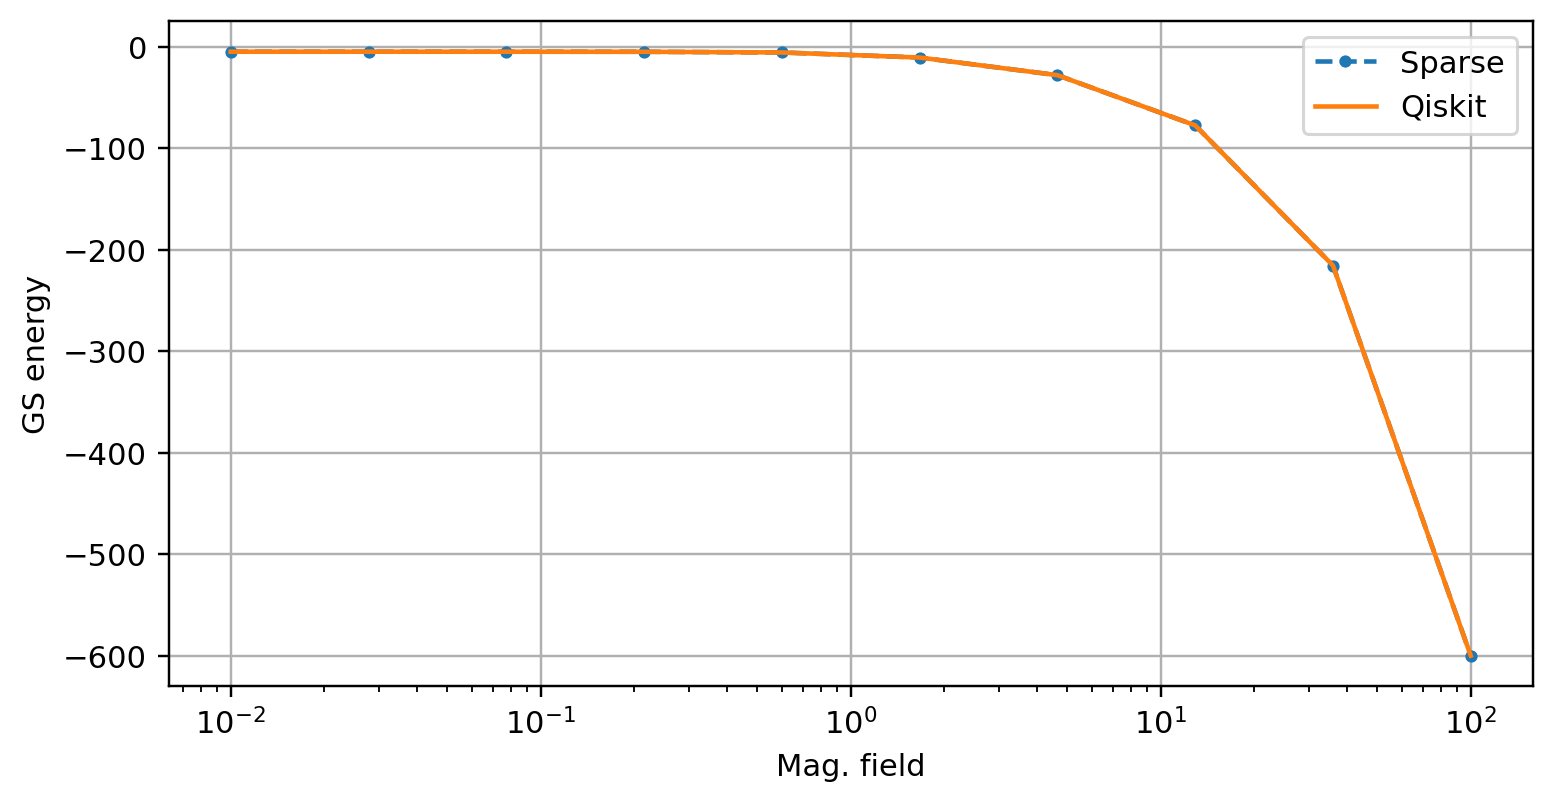

In [143]:
lambdas = np.array([_ for _ in VQE_vals],dtype=np.float) # list of lambda values (the items in the dictionary)
plt.figure(1,dpi=220)
plt.plot(lambdas,Sen,".--")
plt.plot(lambdas,Qen)
plt.xscale("log")
plt.ylabel("GS energy")
plt.xlabel("Mag. field")
plt.legend(["Sparse","Qiskit"])
plt.grid()
print(Sen,Qen)

[9.99975002e-01 9.99806365e-01 9.98495366e-01 9.75478983e-01
 1.56672187e-02 2.13049780e-04 3.17723311e-05 8.84040947e-06
 2.91594549e-06 1.01686452e-06] [-9.99265154e-08 -9.99916249e-01 -9.98503000e-01 -9.88323785e-01
  2.09746302e-03 -1.28670635e-03  7.15976050e-05  1.16912333e-05
 -3.10816478e-06 -7.07962202e-06]


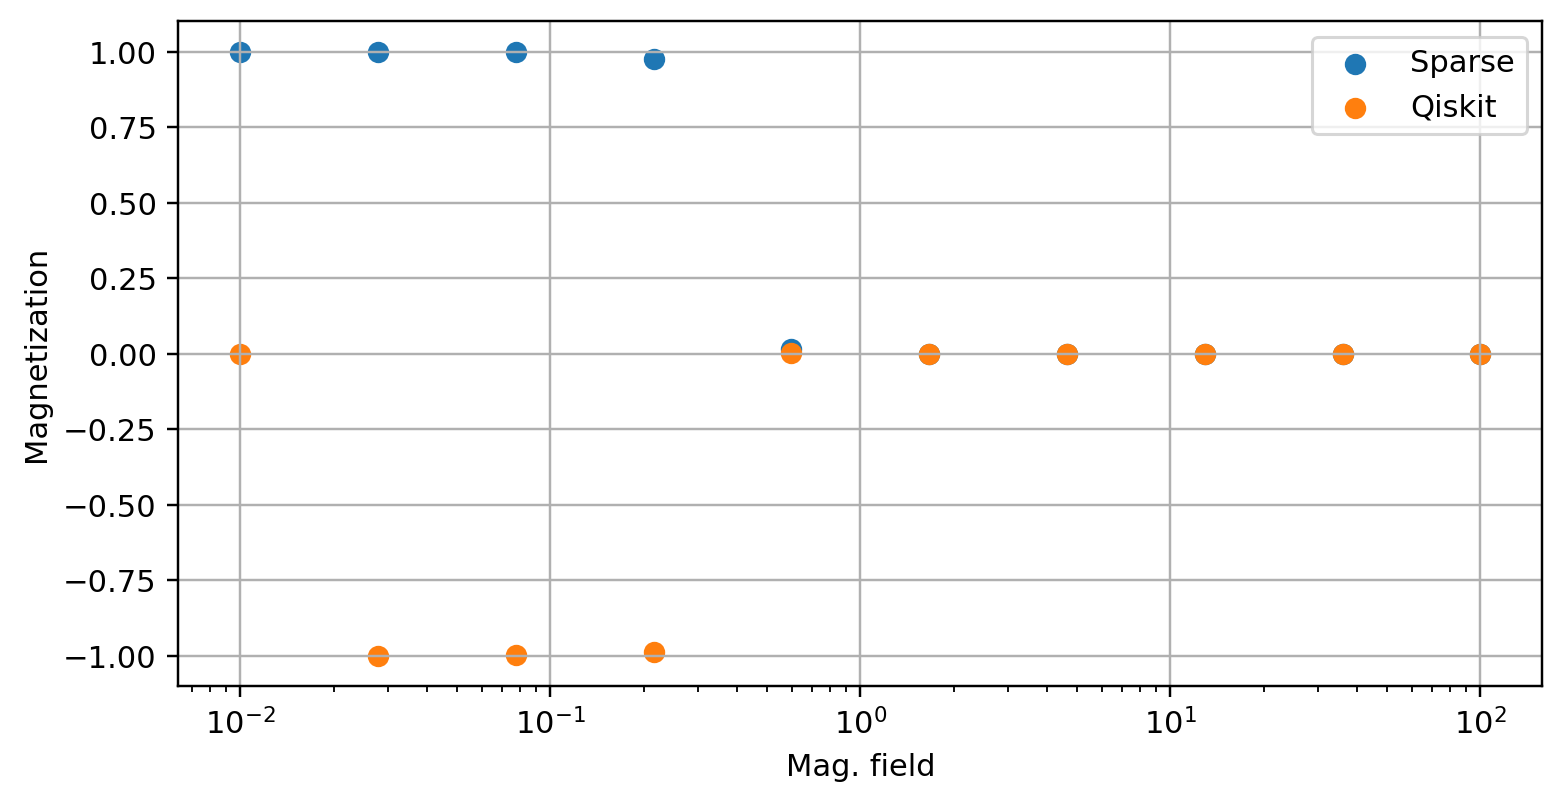

In [134]:
plt.figure(2,dpi=220)
plt.scatter(lambdas,Smags)
plt.scatter(lambdas,Qmags)
plt.xscale('log')
plt.ylabel("Magnetization")
plt.xlabel("Mag. field")
plt.legend(["Sparse","Qiskit"])
plt.grid()
print(Smags,Qmags)

I also tried with the Hamiltonian but he didnt like that, I guess it has to do with ho Niccolo's code constructs the Hamiltonian and what StateFn can accept. Ideally we would construct the Hamiltonian with the routines described in the opflow tutorial